In [1]:
pip install "numpy<2.0" --upgrade

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np

data = np.load("../data/all_imagesfinal.npz")

print(data.files)


['all_imagesfinal']


In [3]:
images = data["all_imagesfinal"]
print(images.shape)


(131057, 32, 32)


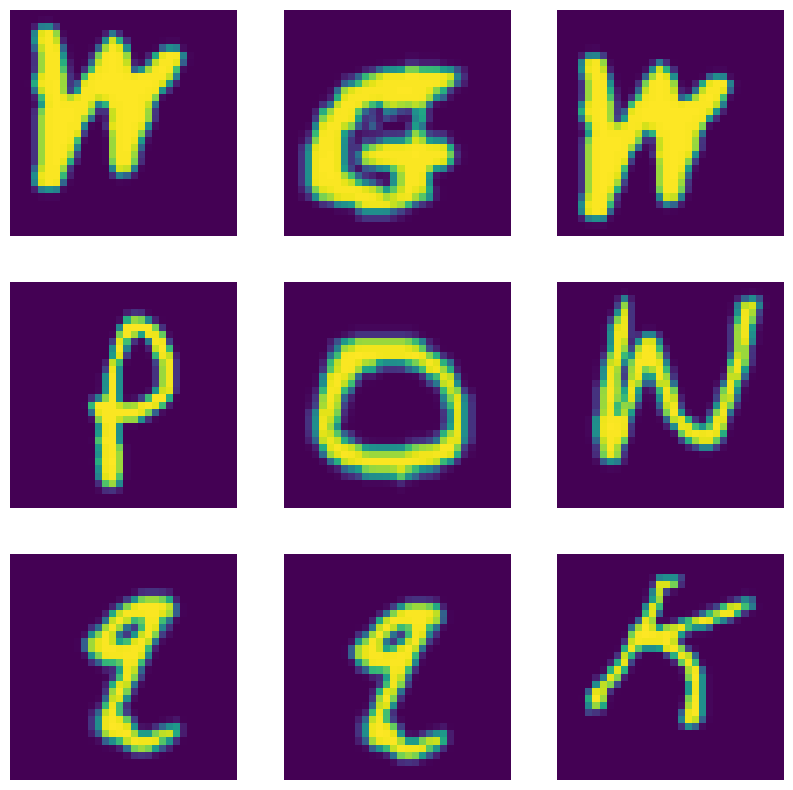

In [4]:
#pour voir quelques images
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

## 1. Altered EMNIST
D'abord, on va chercher a comprendre comment ont été altérées les images du datset pour mieux comprendre notre sujet:

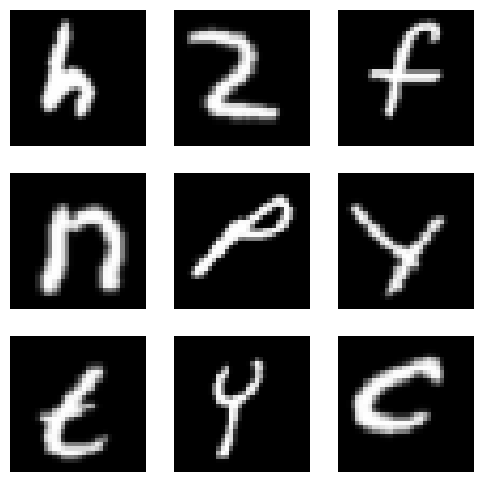

In [5]:
#9 images aleatoires

fig, axes = plt.subplots(3, 3, figsize=(6,6))
for ax in axes.flatten():
    idx = np.random.randint(len(images))
    ax.imshow(images[idx], cmap="gray")
    ax.axis("off")
plt.show()



En observant plusieurs échantillons du dataset EMNIST corrompu, on remarque que les lettres conservent leur structure globale (ce qui signifie une transformation partielle seulement solon moi).

Cependant, elles présentent souvent un aspect inhabituel. Certaines images sont floues, d’autres montrent des traits très fins ou au contraire légèrement épaissis. Plusieurs caractères semblent déformés, comme étirés ou écrasés, ce qui suggère une altération géométrique. 

On ne voit pas de bruit clair, ni de rotation systématique ou de patchs masqués. L’ensemble de ces observations indique que le dataset a probablement subi une forme de floutage (gaussien ou directionnel) et/ou une érosion qui modifie l’épaisseur des traits des lettres.

c'est ce qu'on va chercher a comprendre :

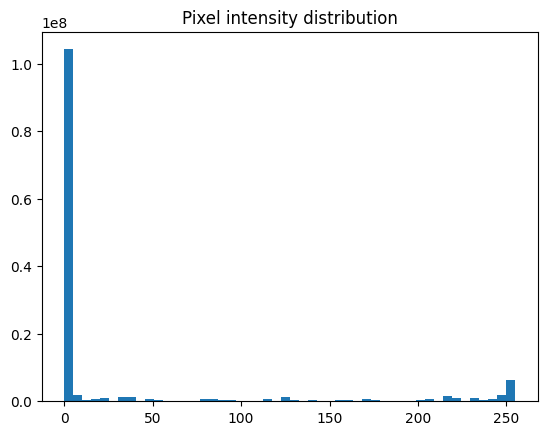

In [6]:
#l’histogramme des pixels pour voir des modifications globales du contraste/du flou...
plt.hist(images.flatten(), bins=50)
plt.title("Pixel intensity distribution")
plt.show()


Même si un pic à 0 est normal à cause du fond noir, on observe ici très peu de niveaux de gris intermédiaires(20-200), ce qui suggère une perte de détails dans les contours.

typique d’un floutage ou d’un lissage ?

In [7]:
print("min pixel:", images.min())
print("max pixel:", images.max())
print("mean pixel:", images.mean())



from scipy.ndimage import laplace
import numpy as np

def sharpness(img):
    return np.mean(np.abs(laplace(img)))

for i in range(5):
    idx = np.random.randint(len(images))
    print("Image", idx, "sharpness =", sharpness(images[idx]))




min pixel: 0.0
max pixel: 255.0
mean pixel: 34.232854690191644
Image 35354 sharpness = 45.62109375
Image 71935 sharpness = 30.04296875
Image 10714 sharpness = 26.931640625
Image 27338 sharpness = 50.828125
Image 38883 sharpness = 35.087890625


In [8]:
sharpness_values = [sharpness(img) for img in images]

print("min sharpness:", np.min(sharpness_values))
print("max sharpness:", np.max(sharpness_values))
print("mean sharpness:", np.mean(sharpness_values))
print("median sharpness:", np.median(sharpness_values))


min sharpness: 7.6796875
max sharpness: 413.876953125
mean sharpness: 32.048882623543534
median sharpness: 30.798828125


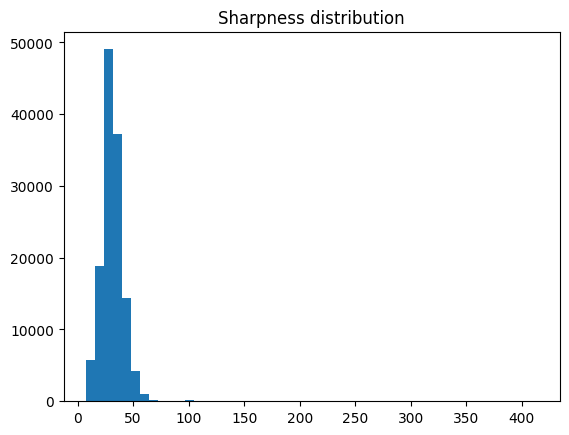

In [9]:
plt.hist(sharpness_values, bins=50)
plt.title("Sharpness distribution")
plt.show()


ok, on voit ici que la distribution de netteté est fortement concentrée entre 20-60, avec une moyenne autour de 32 (mean sharpness: 32.048).

Ces valeurs sont significativement plus faibles que celles attendues pour des lettres manuscrites normales, ce qui indique une forte perte de détails dans les contours.

 L'histogramme, très resserré, montre que cette baisse de netteté concerne presque toutes les images, ce qui suggère que le dataset a subi **une corruption globale de type floutage ou lissage systématique**.

## 2. Unsupervised anomaly detection 
Comme vu en cours, on va maintenant proceder a un AE (autoencoder) pour l'anomaly detection et ainsi identifier les images corrompues

si j'ai bien compris, l’autoencoder apprend à reconstruire les images “normales” du dataset et échoue davantage sur celles qui sont fortement corrompues.
L’erreur de reconstruction devient donc un score d’anomalie permettant d’identifier automatiquement les images les plus dégradées ou atypiques.

#### A-Entrainement de l'AE sur les images corrompues:

In [10]:
#pip install torch

In [11]:
#pip install "numpy<2.0" --upgrade


In [12]:
import torch
from torch.utils.data import TensorDataset, DataLoader

#normalisation en 0-1
x = torch.tensor(images / 255., dtype=torch.float32)

#le modèle attend un canal (131057, 1, 32, 32) ?
x = x.unsqueeze(1)

dataset = TensorDataset(x, x)
loader = DataLoader(dataset, batch_size=128, shuffle=True)


In [13]:
import torch.nn as nn

class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*32, 256),
            nn.ReLU(),
            nn.Linear(256, 64)  # latent space
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 32*32),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out.view(-1, 1, 32, 32)


In [14]:
#entrainement de l'ae
model = AE()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):
    total_loss = 0
    for batch, _ in loader:
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"n° {epoch+1}, loss = {total_loss / len(loader):.6f}")
        

n° 1, loss = 0.026422
n° 2, loss = 0.009379
n° 3, loss = 0.006950
n° 4, loss = 0.005841
n° 5, loss = 0.005126
n° 6, loss = 0.004680
n° 7, loss = 0.004380
n° 8, loss = 0.004185
n° 9, loss = 0.004054
n° 10, loss = 0.003921


on cherche a minimiser l’erreur de reconstruction (MSE):

Si l’image est étrange (floue/distordue), le modèle n’arrive pas à la reconstruire correctement -> erreur élevée.

Maintenant, on a un 1er modèle, \
Pour chaque image, on calcule l’erreur de reconstruction moyenne: \
Plus l’erreur est grande → plus l’image est "anormale"

In [15]:
with torch.no_grad():
    recon_all = model(x).cpu().numpy()

errors = ((recon_all - x.cpu().numpy())**2).mean(axis=(1,2,3))


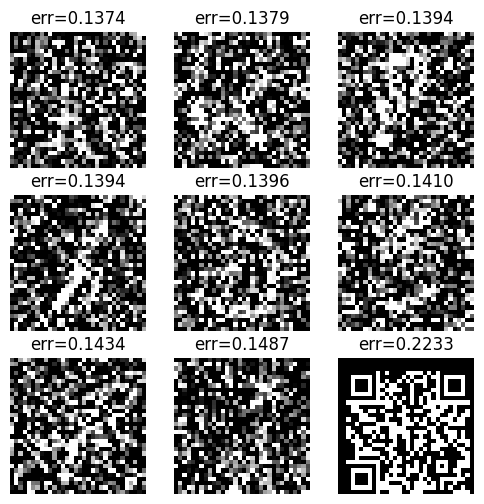

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Top9 images avec plus grande erreur:
idx_sorted = np.argsort(errors)[-9:]

fig, axes = plt.subplots(3, 3, figsize=(6,6))
for ax, idx in zip(axes.flatten(), idx_sorted):
    ax.imshow(images[idx], cmap="gray")
    ax.set_title(f"err={errors[idx]:.4f}")
    ax.axis("off")
plt.show()


effectivement, on voit bien des images avec une grande modification en rapport au dataset initial:

Les images associées aux plus fortes erreurs de reconstruction ne ressemblent plus du tout à des lettres.\
Elles sont extrêmement bruitées, quasi aléatoires, et parfois même complètement aberrantes (ex. QR-code).\
L’autoencoder échoue donc à les reconstruire, ce qui confirme qu’il utilise efficacement l’erreur de reconstruction comme indicateur d’anomalies fortes dans le dataset.

On va essayer de "reconstruire" l'image la + anormale grace a l'AutoEncodeur :

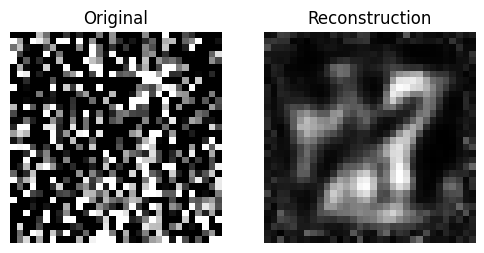

In [19]:
i = idx_sorted[-2]  # la 2eme + anormale

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(images[i], cmap='gray')
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(recon_all[i,0], cmap='gray')
plt.title("Reconstruction")
plt.axis("off")
plt.show()


Face à une image entièrement bruitée, l'AE reconstruit une forme floue et incohérente, confirmant qu’il ne peut pas extraire de structure valide et que cette image est une anomalie majeure.

### Conclusion AutoEncodeur :
L’autoencoder apprend à reconstruire les lettres typiques du dataset, mais il échoue dès que l’image est trop floue, déformée ou totalement bruitée. Les erreurs de reconstruction obtenues servent donc naturellement de scores d’anomalie : les images les plus altérées présentent les erreurs les plus élevées. Cette étape confirme que le modèle capture bien la structure des lettres normales et met en évidence les corruptions présentes dans le dataset.

### B-PCA pour Anomaly Detection

In [20]:
from sklearn.decomposition import PCA

#normalisation 0-1
flat = images.reshape(len(images), -1) / 255.0

#Réduction de dimension
pca = PCA(n_components=50)
proj = pca.fit_transform(flat)
recon_pca = pca.inverse_transform(proj)



on fait une recinstruction PCA :\
Reconstruction PCA = image compressée puis reconstruite

Les images normales seront bien reconstruites mais les anomalies seront très mal reconstruites

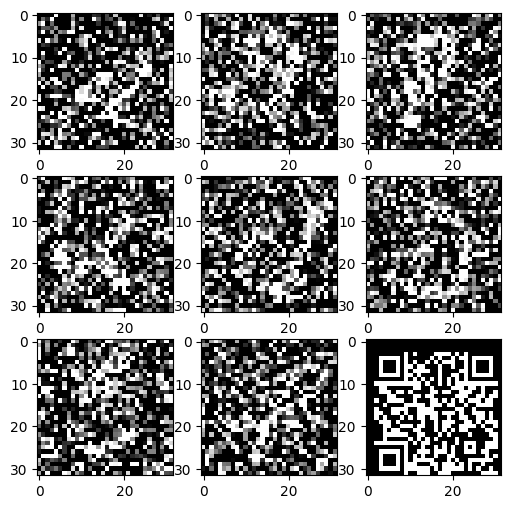

In [21]:
# score d'anomalie
errors_pca = ((flat - recon_pca)**2).mean(axis=1)

# Top 9 images avec plus grande erreur
idx_sorted = np.argsort(errors_pca)[-9:]

fig, axes = plt.subplots(3, 3, figsize=(6,6))
for ax, idx in zip(axes.flatten(), idx_sorted):
    ax.imshow(images[idx], cmap="gray")

Les images ayant la plus forte erreur PCA sont presque identiques à celles détectées par l’autoencoder

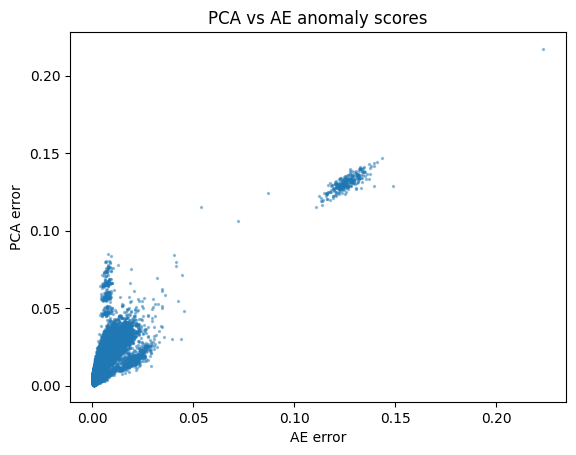

In [22]:
#on compare pca et AE :
plt.scatter(errors, errors_pca, s=2, alpha=0.4)
plt.xlabel("AE error")
plt.ylabel("PCA error")
plt.title("PCA vs AE anomaly scores")
plt.show()


Le nuage de points montre une forte corrélation entre l’erreur **PCA** et l’erreur de **l’autoencoder** : les images que l’un juge anormales sont également repérées par l’autre. On observe deux groupes distincts : un grand cluster avec de faibles erreurs (images normales) et un petit cluster avec des erreurs beaucoup plus élevées (images très corrompues ou bruitées). 

Ce résultat confirme que les deux méthodes détectent les mêmes anomalies structurelles dans le dataset et se renforcent mutuellement.

### Conclusion PCA :
PCA détecte les mêmes anomalies que l’autoencoder, confirmant la présence d’images fortement corrompues et la cohérence des deux méthodes.

On va maintenant chercher à identifier officiellement la corruption:

# 3. Recovering the corrupted dataset

Selon les cas: recuperables vs irrecuperables, on va adopter 2 strategies differentes (en fonction des erreurs AE ou PCA):


In [23]:
threshold = np.percentile(errors, 99)  # top 1% anomalies
recoverable = images[errors < threshold]
unrecoverable = images[errors >= threshold]

#3.2
